<a href="https://colab.research.google.com/github/ljrn8/QuickNotebooks/blob/main/blood_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# White Blood Cell Categorization | Keras 
---

thanks to Pual Mooney for the dataset:
https://www.kaggle.com/datasets/paultimothymooney/blood-cells/code?datasetId=9232&sortBy=voteCount

In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from functools import partial

## Downloading the dataset from kaggle

When reproducing this notebook, a kaggle API token must be located under /content/drive/MyDrive/kaggle.json for it to run. Kaggle API tokens can be downloaded from kaggle.com > sign in > account > create new API token

In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/
!mkdir ~/.kaggle

Mounted at /content/drive


In [6]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list -s 'blood cells'

ref                                                       title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
paultimothymooney/blood-cells                             Blood Cell Images                              108MB  2018-04-21 21:06:13          32158        765  0.7058824        
saurabhshahane/in-hospital-mortality-prediction           In Hospital Mortality Prediction               136KB  2021-09-03 16:04:57           3737        103  0.9411765        
kmader/malaria-bounding-boxes                             Malaria Bounding Boxes                           4GB  2019-05-09 13:37:54           3337        117  0.75             
alexandervc/single-cell-rna-seq-nestorova2016-mouse-hspc  Single Cell RNA seq Nestorova2016 Mouse HSPC    28MB  202

In [8]:
!kaggle datasets download -d 'paultimothymooney/blood-cells'

 98% 106M/108M [00:00<00:00, 237MB/s] 
100% 108M/108M [00:00<00:00, 219MB/s]


In [9]:
!unzip blood-cells.zip > /dev/null 

In [10]:
!tree /content/dataset2-master/ --filelimit 10

/bin/bash: tree: command not found


## Looking at the data

sample image shape:  (240, 320, 3)


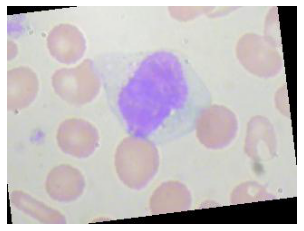

In [13]:
base_dir = '/content/dataset2-master/dataset2-master/images/'
fname = os.listdir(base_dir + 'TRAIN/MONOCYTE/')[0]
sample_image = plt.imread(base_dir + 'TRAIN/MONOCYTE/' + fname)
print('sample image shape: ', sample_image.shape)
plt.imshow(sample_image)
plt.axis('off')
plt.show()

MONOCYTE


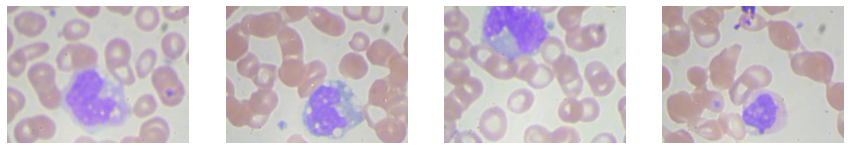

LYMPHOCYTE


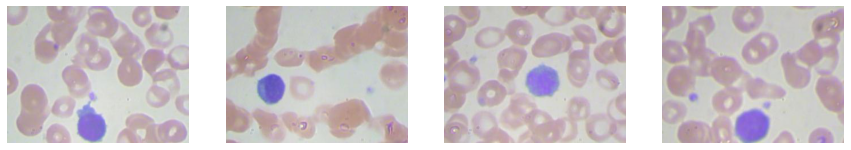

EOSINOPHIL


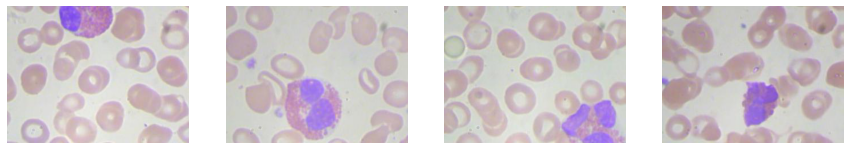

NEUTROPHIL


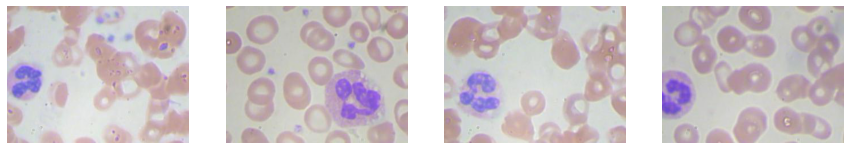

In [14]:
def peak(path):
    ''' looks at the first 4 images '''
    fig, axs = plt.subplots(1,4, figsize=(15,7))
    for count, (ax, filename) in enumerate(zip(axs, os.scandir(path))):
        image = plt.imread(filename.path)
        ax.imshow(image)
        ax.axis('off')
        if count == 4:
            break
    plt.show()

subcats = ['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
for subcat in subcats:
    print(subcat)
    peak(base_dir + 'TEST_SIMPLE/' + subcat + '/')   

## Preprocessing & Setup

In [15]:
base_dir = '/content/dataset2-master/dataset2-master/images/'

def load_data(preprocess=None, batch=32):
    test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir + 'TEST/', seed=0, batch_size=batch
    )
    valid_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir + 'TRAIN/', seed=0, batch_size=batch,
        validation_split=0.2, subset="validation", 
    )
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir + 'TRAIN/', seed=0, batch_size=batch,
        validation_split=0.2, subset="training", 
    )
    ds = test_ds.concatenate(train_ds).concatenate(valid_ds)
    ds = ds.shuffle(1000)
    if preprocess:
        for im_b, _ in ds:
            im_b = preprocess(im_b) # careful of ram limitations

    return test_ds, train_ds, valid_ds, ds

test_ds, train_ds, valid_ds, ds = load_data()

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [16]:
def preprocess_custom(ds): 
    AUTOTUNE = tf.data.AUTOTUNE
    resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(240, 320),
        layers.Rescaling(1./255.)
    ])
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


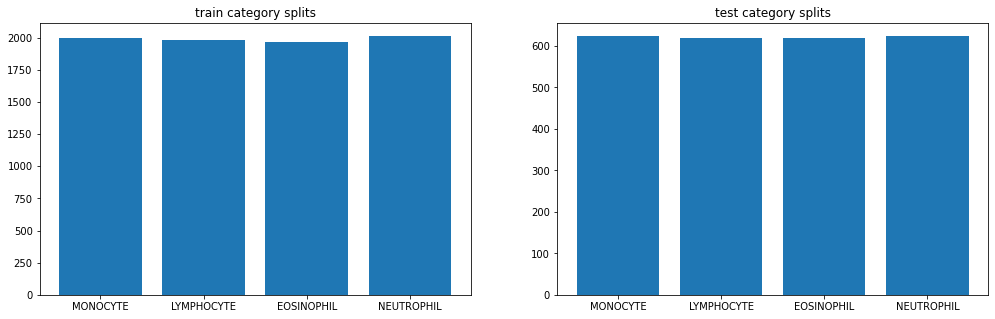

In [17]:
def plot_categories(ds, categories, ax=plt):
    labels_ds = ds.map(lambda x, y: y)
    labels_np = np.concatenate(list(labels_ds.as_numpy_iterator()))
    uniq, counts = np.unique(labels_np, return_counts=True)
    ax.bar(categories, counts)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
ax1.set_title('train category splits')
plot_categories(train_ds, subcats, ax=ax1)
ax2.set_title('test category splits')
plot_categories(test_ds, subcats, ax=ax2)
plt.show()    

## Model Iteration

In [ ]:
for im_b, lab_b in train_ds.take(1):
    print(f'image batch shape = {im_b.shape}, label batch shape = {lab_b.shape}')

image batch shape = (64, 256, 256, 3), label batch shape = (64,)


### InceptionV3

In [ ]:
test_ds, train_ds, valid_ds, ds = load_data(keras.applications.inception_v3.preprocess_input)

In [ ]:
model = keras.applications.InceptionV3(
    include_top=True,
    weights=None, 
    input_shape=[256, 256, 3],
    classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=6)
history = model.fit(train_ds, epochs=30, callbacks=[early_stopping_cb], validation_data=valid_ds)

Epoch 1/30
125/125 [==============================] - 140s 702ms/step - loss: 1.3662 - accuracy: 0.4008 - val_loss: 36.3588 - val_accuracy: 0.2546
Epoch 2/30
125/125 [==============================] - 83s 663ms/step - loss: 0.9682 - accuracy: 0.5385 - val_loss: 1.4865 - val_accuracy: 0.2516
Epoch 3/30
125/125 [==============================] - 83s 662ms/step - loss: 0.8394 - accuracy: 0.5722 - val_loss: 2.0960 - val_accuracy: 0.4731
Epoch 4/30
125/125 [==============================] - 83s 659ms/step - loss: 0.6484 - accuracy: 0.6903 - val_loss: 10.8863 - val_accuracy: 0.4420
Epoch 5/30
125/125 [==============================] - 87s 691ms/step - loss: 0.5877 - accuracy: 0.7577 - val_loss: 195.7347 - val_accuracy: 0.5334
Epoch 6/30
125/125 [==============================] - 83s 662ms/step - loss: 0.5137 - accuracy: 0.7944 - val_loss: 2.1464 - val_accuracy: 0.3024
Epoch 7/30
125/125 [==============================] - 82s 651ms/step - loss: 0.3981 - accuracy: 0.8433 - val_loss: 0.5441 - v

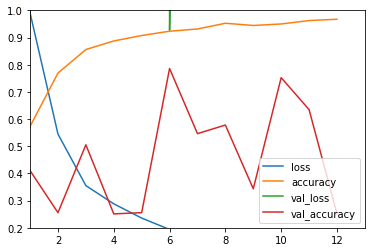

In [ ]:
pd.DataFrame(history.history).plot(xlim=[1, 13], ylim=[0.2, 1])
plt.show()

### ResNet50V2

In [ ]:
test_ds, train_ds, valid_ds, ds = load_data(keras.applications.resnet_v2.preprocess_input)

In [ ]:
model = keras.applications.ResNet50V2(
    include_top=True,
    weights=None, 
    input_shape=[256, 256, 3],
    classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=6)
history = model.fit(train_ds, epochs=30, callbacks=[early_stopping_cb], validation_data=valid_ds)

Epoch 1/30
249/249 [==============================] - 144s 409ms/step - loss: 1.4477 - accuracy: 0.3167 - val_loss: 10.1518 - val_accuracy: 0.4119
Epoch 2/30
249/249 [==============================] - 95s 379ms/step - loss: 0.9905 - accuracy: 0.5732 - val_loss: 17.1429 - val_accuracy: 0.4103
Epoch 3/30
249/249 [==============================] - 95s 380ms/step - loss: 0.5448 - accuracy: 0.7694 - val_loss: 256.9798 - val_accuracy: 0.2557
Epoch 4/30
249/249 [==============================] - 95s 381ms/step - loss: 0.3552 - accuracy: 0.8559 - val_loss: 2.2744 - val_accuracy: 0.5053
Epoch 5/30
249/249 [==============================] - 95s 380ms/step - loss: 0.2882 - accuracy: 0.8874 - val_loss: 34.0235 - val_accuracy: 0.2511
Epoch 6/30
249/249 [==============================] - 95s 381ms/step - loss: 0.2358 - accuracy: 0.9075 - val_loss: 111.2229 - val_accuracy: 0.2557
Epoch 7/30
249/249 [==============================] - 95s 380ms/step - loss: 0.1937 - accuracy: 0.9233 - val_loss: 0.9276 

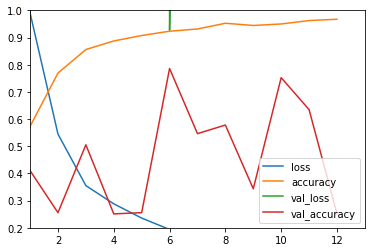

In [ ]:
pd.DataFrame(history.history).plot(xlim=[1, 13], ylim=[0.2, 1])
plt.show()

### DenseNet121

In [ ]:
test_ds, train_ds, valid_ds, ds = load_data()
full_train_ds = valid_ds.concatenate(train_ds) # larger ds

In [ ]:
ds = preprocess_custom(ds)

In [ ]:
model = tf.keras.applications.DenseNet121( # less params
    include_top=True, weights=None, 
    input_shape=[256, 256, 3], classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.003), # slower lr
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=6) # increase patience
history = model.fit(full_train_ds, epochs=30, callbacks=[early_stopping_cb], validation_data=test_ds)

Epoch 1/30
312/312 [==============================] - 215s 482ms/step - loss: 0.7602 - accuracy: 0.6629 - val_loss: 7.7872 - val_accuracy: 0.3249
Epoch 2/30
312/312 [==============================] - 146s 468ms/step - loss: 0.3910 - accuracy: 0.8396 - val_loss: 64.7380 - val_accuracy: 0.2505
Epoch 3/30
312/312 [==============================] - 146s 468ms/step - loss: 0.2360 - accuracy: 0.9102 - val_loss: 20.1172 - val_accuracy: 0.3675
Epoch 4/30
312/312 [==============================] - 146s 468ms/step - loss: 0.2005 - accuracy: 0.9239 - val_loss: 71.0259 - val_accuracy: 0.2493
Epoch 5/30
312/312 [==============================] - 147s 472ms/step - loss: 0.1691 - accuracy: 0.9367 - val_loss: 3.3588 - val_accuracy: 0.5279
Epoch 6/30
312/312 [==============================] - 147s 469ms/step - loss: 0.1474 - accuracy: 0.9455 - val_loss: 64.4871 - val_accuracy: 0.2493
Epoch 7/30
312/312 [==============================] - 147s 469ms/step - loss: 0.1238 - accuracy: 0.9540 - val_loss: 34.2

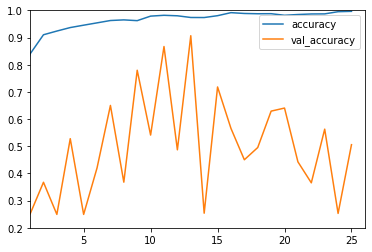

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(xlim=[1, 26], ylim=[0.2, 1])
plt.show()

wtf

### Custom ResNet 
much credit to Aurelien Geron; Hands on machine learning w/ scikit learn keras & tensorflow

In [22]:
DefaultConv = partial(layers.Conv2D, kernel_size=3, strides=1, 
                    padding='same', kernel_initializer='he_normal')

class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.skip_bn = layers.BatchNormalization()
        self.layers = [
            DefaultConv(filters, strides=strides),
            layers.BatchNormalization(),
            self.activation,
            DefaultConv(filters),
            layers.BatchNormalization()
        ]
        self.skip_layers = [
            # make sure skip connection gets scaled 
            DefaultConv(filters, strides=strides), 
            layers.BatchNormalization(),
        ]

    def call(self, inputs):
        Z = inputs
        for layer in self.layers:
            Z = layer(Z)
        Z_skip = inputs
        for skip_layer in self.skip_layers:
            Z_skip = skip_layer(Z_skip)
        return self.activation(Z + Z_skip)


def Res(input_shape, classes):
    # resnet 18, modified with dropout layers 
    # and less filters
    input = keras.Input(shape=input_shape)
    X = DefaultConv(64, kernel_size=7, strides=2)(input)
    X = layers.MaxPooling2D(3, strides=2)(X)
    
    # first residual pairs
    for _ in range(2):
        X = ResidualBlock(64)(X)  
    for _ in range(2):
        X = ResidualBlock(128)(X)
        
    # drop out and residual pair
    X = layers.Dropout(0.5)(X)
    X = ResidualBlock(256, strides=2)(X)
    X = ResidualBlock(256)(X)
    
    # drop out and large block ? (2)
    X = layers.Dropout(0.5)(X)
    X = ResidualBlock(512, strides=2)(X)
    
    # final pooling 
    X = layers.AveragePooling2D()(X)
    
    # FC layer & dropout for classification 
    X = layers.Dense(10, kernel_initializer='he_normal', 
                     activation='relu')(X)
    X = layers.Dropout(0.5)(X)
    output = layers.Dense(classes, activation='softmax')(X)

    model = keras.Model(inputs=input, outputs=output)
    model.compile(optimizer='adam',
                  loss='SparseCategoricalCrossentropy',
                  metrics=['accuracy'])
    return model

model = Res(input_shape=[256, 256, 3], classes=4)

In [29]:
test_ds, train_ds, valid_ds, ds = load_data(batch=20)
full_train_ds = valid_ds.concatenate(train_ds) 

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [26]:
ds = preprocess_custom(ds)

# TODO
- custom training loop

In [28]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=6) 
history = model.fit(full_train_ds, epochs=30, callbacks=[early_stopping_cb], validation_data=test_ds)

Epoch 1/30


InvalidArgumentError: ignored